# Time Series

## Intro

In [1]:
#for time series we are going to use a new library called statsmodel
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# the column of interest is CO2, which of course changes when someone unpredictably enters the room
occupancy = pd.read_csv('data/occupancy.csv')
occupancy.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2/2/2015 14:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2/2/2015 15:00,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2/2/2015 16:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2/2/2015 17:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2/2/2015 18:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [3]:
#since this is a TS, we make the date into the index and we force it's frequency to be hourly
occupancy['date'] = pd.to_datetime(occupancy['date'])
occupancy.index = pd.DatetimeIndex(occupancy['date'], freq='H')
display(occupancy.head())

/var/folders/dk/ht9wngxs4r51l9tbk0_y94000000gp/T/ipykernel_9869/1905027134.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  occupancy.index = pd.DatetimeIndex(occupancy['date'], freq='H')


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,,
2015-02-02 14:00:00,2015-02-02 14:00:00,23.7000,26.272,585.200000,749.200000,0.004764,1
2015-02-02 15:00:00,2015-02-02 15:00:00,23.7180,26.290,578.400000,760.400000,0.004773,1
2015-02-02 16:00:00,2015-02-02 16:00:00,23.7300,26.230,572.666667,769.666667,0.004765,1
2015-02-02 17:00:00,2015-02-02 17:00:00,23.7225,26.125,493.750000,774.750000,0.004744,1
2015-02-02 18:00:00,2015-02-02 18:00:00,23.7540,26.200,488.600000,779.000000,0.004767,1


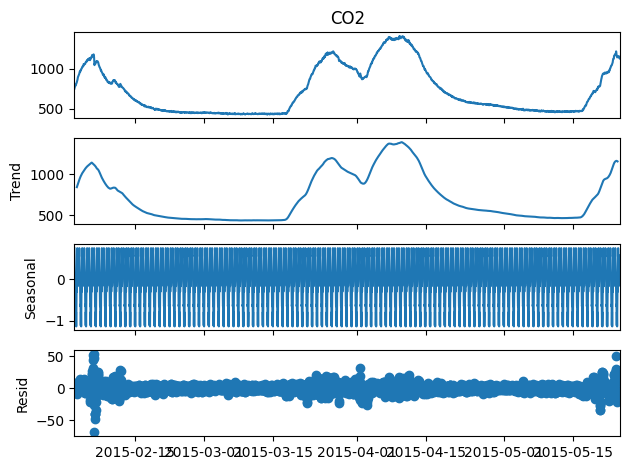

In [4]:
# seasonal decompose tries to check for multiple "potential" seasonal periods.
# in this case we have a daily cycle. Maybe there is a plant in the room? 
decomp = sm.tsa.seasonal_decompose(occupancy['CO2'])
decomp.plot()
plt.show()

## Autoregressive Models

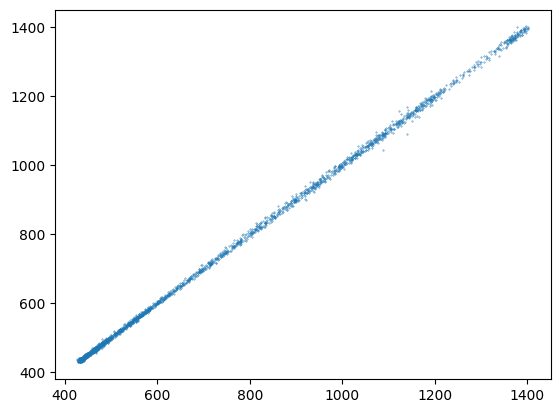

In [5]:
# we want to check if there is a relation between consecutive datapoints. 
# this is a requisite for an AR model
plt.scatter(occupancy['CO2'][:-1],occupancy['CO2'][1:],s=0.1)
plt.show()

In [6]:
# the simplest autoregressive model is to do a linear regression on the previous observation
# here we leave the last 10 datapoints out of our model for validation
# in time series the test and validation set must not interleave, to avoid "information contamination"
from statsmodels.tsa.ar_model import AutoReg as AR

#create train and test sets
train =  occupancy['CO2'][:-10] 
test = occupancy['CO2'][-10:]
#create model
model = AR(train, lags = [1])
#train model
model_fit = model.fit() #use last predicted value to predict following value
#make prediction
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1) #predict on the slice of data yets unseen for training

In [7]:
#just like in standard LR we can find an intercept and a gradient
print(model_fit.params)

const    -0.029427
CO2.L1    1.000253
dtype: float64


In [8]:
# when we compare our AR prediction with the 10 reserved datapoints
# we see that this is not the best model (okay, it's crap), since it "runs away" immediately
pd.DataFrame({'observed':test, 'predicted':predictions})

,observed,predicted
2015-05-24 04:00:00,1153.250000,1152.762619
2015-05-24 05:00:00,1152.400000,1153.025305
2015-05-24 06:00:00,1146.166667,1153.288058
2015-05-24 07:00:00,1145.400000,1153.550877
2015-05-24 08:00:00,1140.800000,1153.813763
2015-05-24 09:00:00,1150.250000,1154.076715
2015-05-24 10:00:00,1129.200000,1154.339734
2015-05-24 11:00:00,1125.800000,1154.602820
2015-05-24 12:00:00,1123.000000,1154.865972
2015-05-24 13:00:00,1124.000000,1155.129191


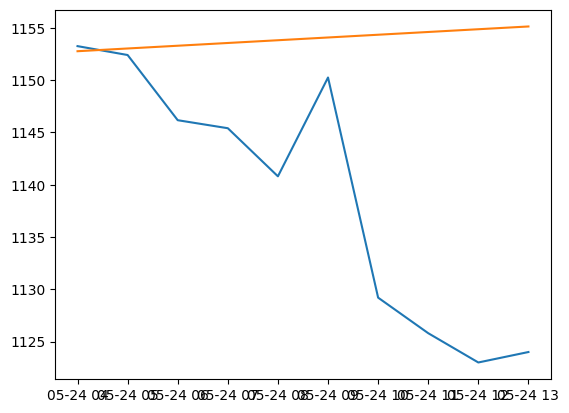

In [9]:
# a more visual check of the run away effect
plt.plot(test)
plt.plot(predictions)
plt.show()

In [10]:
# we can imporve our fit at the cost of considering more previous points.
# this helps to avoid running away since some coefficients will "balance" others
# but more terms also mean a more complex model that is more sensitive to noise
# this may lead to overfitting, a concept we will delve into later

#create train and test sets
train, test = occupancy['CO2'][:-10], occupancy['CO2'][-10:]
#create model
model = AR(train, lags=[10])
# train model
model_fit = model.fit() #use previous 10 predicted values to predict next value
#make prediction
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
print(model_fit.params)

const      1.557600
CO2.L10    0.999828
dtype: float64


In [11]:
# again, not the best model, but certainly much better!
pd.DataFrame({'observed':test, 'predicted':predictions})

,observed,predicted
2015-05-24 04:00:00,1153.250000,1215.099225
2015-05-24 05:00:00,1152.400000,1195.352615
2015-05-24 06:00:00,1146.166667,1174.756152
2015-05-24 07:00:00,1145.400000,1161.558418
2015-05-24 08:00:00,1140.800000,1157.609096
2015-05-24 09:00:00,1150.250000,1140.362058
2015-05-24 10:00:00,1129.200000,1141.861800
2015-05-24 11:00:00,1125.800000,1146.694303
2015-05-24 12:00:00,1123.000000,1150.610298
2015-05-24 13:00:00,1124.000000,1153.859740


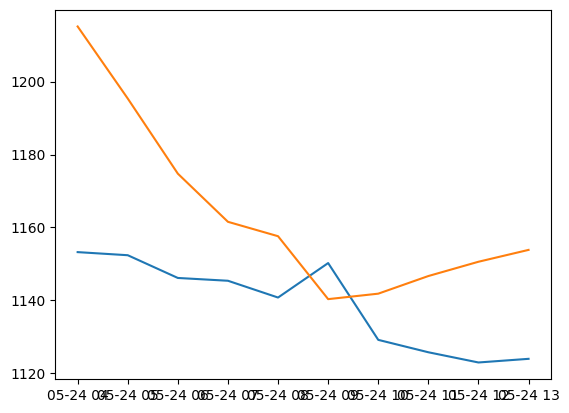

In [12]:
# and visually
plt.plot(test)
plt.plot(predictions)
plt.show()

In [13]:
# we can also "cheat" and try to predict only the trend (removing seasonality and error)
# this typically does wonders, but:
# a) you lose a few bits of your series at the beginning and end because of the seasonality detection
#    this can be a problem because you may "run away" at the end and be already "lost" when you get to 
#    unobserved timestamps 
# b) you have to add error back (as well as seasonality) to have a fair comparison
# still, this can be a powerful technique for forecasting

# create train and test sets
train, test = decomp.trend.dropna()[:-25], decomp.trend.dropna()[-25:-15]
# create model
model = AR(train, lags = [10])
# train model
model_fit = model.fit() #let's go back only 3 hours to avoid overfitting
#make prediction
predictions = model_fit.predict(start=len(train), end=(len(train)+len(test)-1), dynamic=False)
print(model_fit.params)

const        1.642110
trend.L10    0.998604
dtype: float64


In [14]:
# ahh, if life could always return models like this...
pd.DataFrame({'observed':test, 'predicted':predictions})

,observed,predicted
2015-05-23 01:00:00,1086.253075,1014.855695
2015-05-23 02:00:00,1093.463095,1021.341074
2015-05-23 03:00:00,1100.708234,1027.977284
2015-05-23 04:00:00,1107.701984,1034.849969
2015-05-23 05:00:00,1114.506151,1041.827022
2015-05-23 06:00:00,1121.678026,1049.209758
2015-05-23 07:00:00,1128.693651,1057.057122
2015-05-23 08:00:00,1134.670734,1064.728691
2015-05-23 09:00:00,1139.901984,1072.207820
2015-05-23 10:00:00,1144.528026,1079.406091


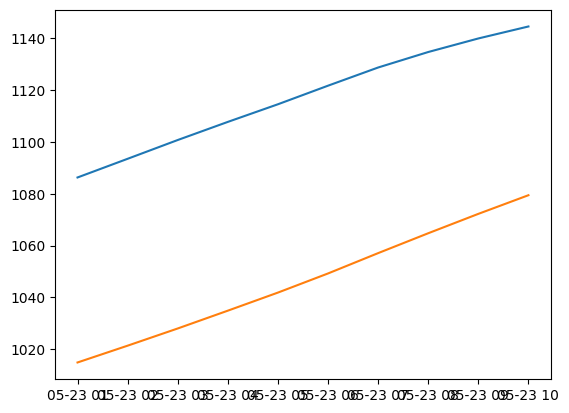

In [15]:
# and visually
plt.plot(test)
plt.plot(predictions)
plt.show()

## Moving average models

In [16]:
#moving average models are not about computing moving averages
#they are about using the previous forecast **errors** as the input for the next prediction
#we are now in a "one step ahead" forecasting

### (ARI)MA - Auto Regressive Integrated Moving Average
Try first without the ARI component

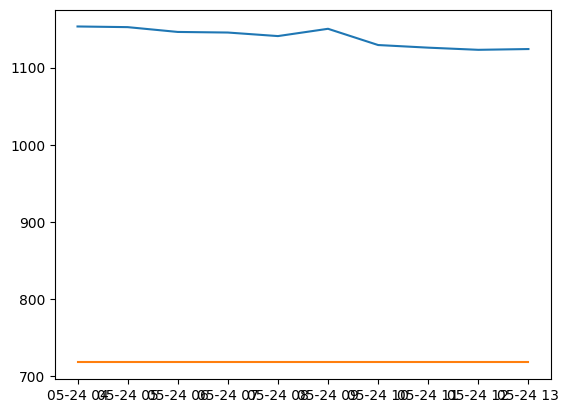

In [17]:
#we expect this to be bad! Error alone in a step is a bad predictor of the value of the next step
from statsmodels.tsa.arima.model import ARIMA

# no train-test à priori separation: "one step ahead" means that we predict for some timestamps but then use the real observation of 
# those timestamps to predict further 
# create model
model = ARIMA(occupancy['CO2'], order=(0, 0, 0))  #The 0 her means we are not usring the AR capability of ARMA
# train model
model_fit = model.fit()
#make prediction
predictions = model_fit.predict(len(occupancy['CO2'])-10, len(occupancy['CO2'])-1)

#okay, bad, check
pd.DataFrame({'observed':occupancy.CO2[-10:], 'predicted':predictions})

# ahahaha :'(
plt.plot(occupancy.CO2[-10:])
plt.plot(predictions)
plt.show()

### ARIMA 

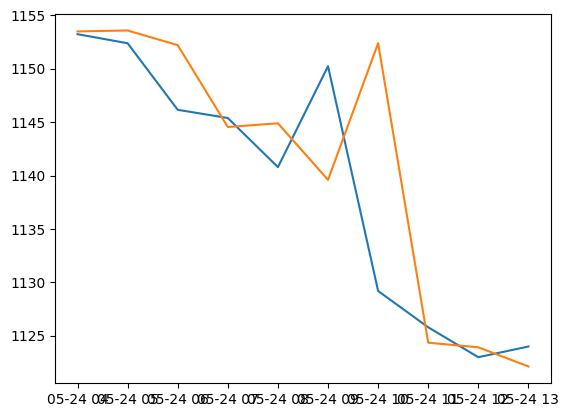

In [18]:
# but from the ashes, we combine AR with MA and we get an actually decent model...
from statsmodels.tsa.arima.model import ARIMA

#create model
model = ARIMA(occupancy['CO2'], order=(2, 1, 0)) 
# train model
model_fit = model.fit()
# make prediction
predictions = model_fit.predict(len(occupancy['CO2'])-10, len(occupancy['CO2'])-1)

# I mean, it's not perfect, but we could do worse as well
pd.DataFrame({'observed':occupancy.CO2[-10:], 'predicted':predictions})

plt.plot(occupancy.CO2[-10:])
plt.plot(predictions)
plt.show()